# Pipeline
This is one example how to use the pipeline and generate new data samples.
Please use this next to the documentation to understand how to use the pipeline.

To use the pipeline to generate samples you need a generator $G$, that is capable of generating the data and a classificator $C$ to classify the data.
The other hyperparameter are settings that can be adjusted according to personal interest.

In [1]:
# General
import torch

# Import the models and pipeline
from models import LeNet5, CGanGenerator

# Import src folder
import sys
import os
from pathlib import Path

home = Path(os.path.abspath('')).parent
sys.path.append(os.path.join(home, "src"))

# Now import alva
from alva import generate_samples, generate_samples_with_iterative_epsilons

# Import to display result
from utils import plot_prediction_switch, set_random_seed

# Import to load config
from omegaconf import OmegaConf

### Variables
Following are variables are used for the pipeline.
The hyperparameters are loaded from a config.yaml in `config/alva_example_config.yaml` and `config/generator_hparams_config.yaml`.
- CLASSIFIER: The classifier $C$ that will be used by the pipeline. The pipeline takes the whole model.
- GENERATOR: The classifier $G$ that will be used by the pipeline. The pipeline takes the whole model.
- TARGET_CLASS: The class that will be generated by $G$.
- EPSILON: The epsilon that will perturbated the data.
- N_GENERATED_SAMPLES: The number of samples to generate.
- N_TIMEOUT: The number of trials before abort or continue higher epsilon (depends on called function).

In [2]:
# Paths to set
# The path to the classifier, that will be used by the pipeline. It can be a path to the models weights or the model will be passed directly.
CLASSIFIER_STATE_DICT_PATH = r"models\state_dicts\lenet5.pt"
# The path to the generator, that will be used by the pipeline. It can be a path to the models weights or the model will be passed directly.
GENERATOR_STATE_DICT_PATH = r"models\state_dicts\conditional_gan_generator.pt"

# Load config
cfg_alva = OmegaConf.load(r"config/alva_example_config.yaml")
cfg_generator = OmegaConf.load(r"config/generator_hparams_config.yaml")

# Set random seed for reproducibility
set_random_seed(0)

# Get the device for cuda optimization
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the classifier
classifier = LeNet5()
classifier.load_state_dict(torch.load(CLASSIFIER_STATE_DICT_PATH))
classifier.to(DEVICE)

# Load the Generator
generator = CGanGenerator(cfg_generator.LATENT_DIM, tuple(cfg_generator.OUTPUT_DIM))
generator.load_state_dict(torch.load(GENERATOR_STATE_DICT_PATH))
generator.to(DEVICE)

# Number of samples to generate
N_GENERATED_SAMPLES=cfg_alva.N_GENERATED_SAMPLES

# Number of trials per epsilon before algorithm continues with higher perturbation or time out
N_TIMEOUT = cfg_alva.N_TIMEOUT

# Weighting factor of perturbation (between 0 and 1)
EPSILON = cfg_alva.EPSILON

# Target of class that will be created. In MNIST examples now samples will be generated for a number 1
TARGET_CLASS = cfg_alva.TARGET_CLASS
TARGET = torch.LongTensor([TARGET_CLASS]).to(DEVICE)

## Generate samples

First we try to generate samples with $TARGET$ and a specific $EPSILON$

Generated 25 adversarial samples with generator


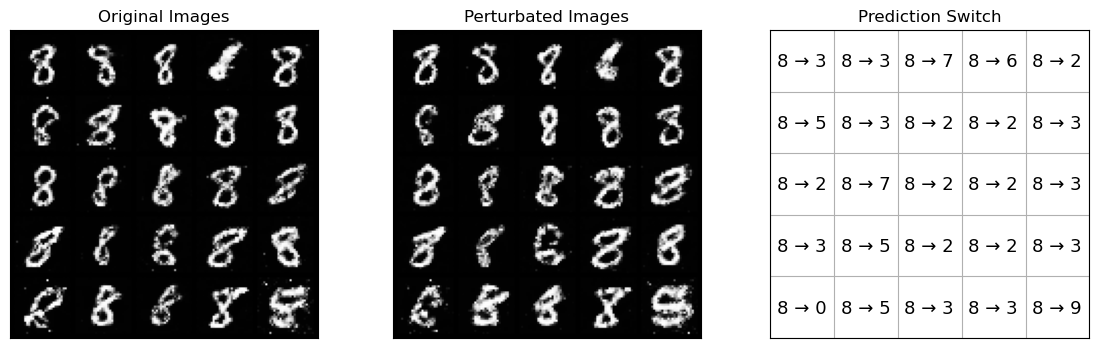

In [3]:
# generate samples will return the noise (z), label (y) with the perturbated version with per_z and per_y
z, y, per_z, per_y = generate_samples(classifier, generator, DEVICE, TARGET, N_GENERATED_SAMPLES, N_TIMEOUT, EPSILON)

# To get the image of the number generate the images with the generator,
x, per_x = generator(z).detach(), generator(per_z).detach()

# Display the result
print(f"Generated {len(z)} adversarial samples with generator")
if len(z) >= 25:
    plot_prediction_switch(x, y, per_x, per_y)

If you are not sure which $EPSILON$ to choose, you can call the function generate_samples_with_iterative_epsilon. This can be used to automatically get the next higher epsilon, if not enough values produced.

Try to generate 25 samples with epsilon = 0.1
Timeout (2000) reached. 13 images returned.
Generated 13 samples
Try to generate 12 samples with epsilon = 0.15
Generated 12 samples
Generated 25 adversarial samples with generator


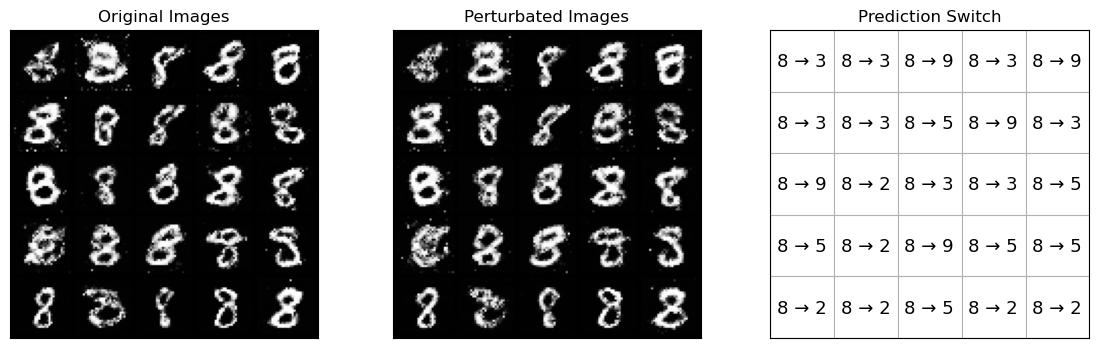

In [4]:
# generate samples will return the noise (z), label (y) with the perturbated version with per_z and per_y
# No epsilon provided. If you want to enforce specific epsilon provide them as list like epsilons = [0.1, 0.2, 0.3]. If you want to know which epsilon was chosen for generation, provide the argument "return_epsilons" = true.
z, y, per_z, per_y = generate_samples_with_iterative_epsilons(classifier, generator, DEVICE, TARGET, N_GENERATED_SAMPLES, N_TIMEOUT)

# To get the image of the number generate the images with the generator,
x, per_x = generator(z).detach(), generator(per_z).detach()

# Display the result
print(f"Generated {len(z)} adversarial samples with generator")
if len(z) >= 25:
    plot_prediction_switch(x, y, per_x, per_y)